# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Для привлечения клиентов сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Но возникла следующая проблема: при отмене бронирования клиентом компания терпела убытки. Для решения проблемы необходимо разработать модель машинного обучения, которая предсказывает отказ от брони. Клиенту, который определяется моделью как потенциально отказавшийся от брони, предлагается внести депозит. Депозит составляет 80% от стоимости номера за одни сутки и затрат на разовую уборку.

## Исходные данные
Заказчиком было предоставлено два датасета: с обучающими данными и тестовыми. В тестовом датасете содержатся данные за 2017 год (8 месяцев), в обучающем - за 2015 год (6 месяцев) и 2016 год (12 месяцев).

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затратами на обслуживание: как при подготовке номера, так и при проживании постояльца. В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


## Загрузка данных и библиотек

Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,f1_score, roc_auc_score, roc_curve, accuracy_score 
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

Открываем файлы и сохраняем данные в датафреймы

In [2]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

## Предобработка и исследовательский анализ данных

***Описание данных***

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:

* `id` — номер записи;
* `adults` — количество взрослых постояльцев;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type` — тип заказчика:
    * `Contract` — договор с юридическим лицом;
    * `Group` — групповой заезд;
    * `Transient` — не связано с договором или групповым заездом;
    * `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_canceled` — отмена заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:
    * `SC` — нет дополнительных опций;
    * `BB` — включён завтрак;
    * `HB` — включён завтрак и обед;
    * `FB` — включён завтрак, обед и ужин.
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type` — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.

### Таблица `hotel_train`

In [3]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

* необходимо удалить столбец id, так как он дублирует индекс;
* в столбцах `lead_time`, `adults`, `children`, `babies` необходимо заменить тип данных на int.

Удалим столбeц `id`

In [4]:
hotel_train = hotel_train.drop('id', axis=1)

В столбцах `lead_time`, `adults`, `children`, `babies` заменим тип данных на int

In [5]:
hotel_train[['lead_time', 'adults', 'children', 'babies']] = (
    hotel_train[['lead_time', 'adults', 'children', 'babies']].astype('int')
)

In [6]:
hotel_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7,2015,July,27,1,0,1,1,0,...,0,0,0,A,0,0,Transient,0,0,1
1,0,14,2015,July,27,1,0,2,2,0,...,0,0,0,A,0,0,Transient,0,1,2
2,0,0,2015,July,27,1,0,2,2,0,...,0,0,0,C,0,0,Transient,0,0,2
3,0,9,2015,July,27,1,0,2,2,0,...,0,0,0,C,0,0,Transient,0,1,2
4,1,85,2015,July,27,1,0,3,2,0,...,0,0,0,A,0,0,Transient,0,1,3


In [7]:
hotel_train['is_canceled'].value_counts()

0    41185
1    24044
Name: is_canceled, dtype: int64

* Значения корректные

In [8]:
hotel_train['lead_time'].value_counts()

0      3423
1      1984
2      1156
3      1051
4       994
       ... 
345       2
352       1
340       1
362       1
373       1
Name: lead_time, Length: 369, dtype: int64

График распределения

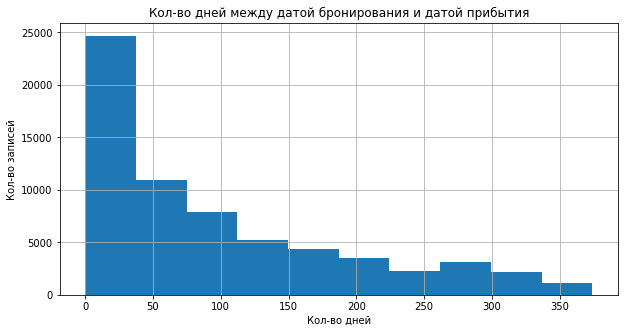

In [9]:
hotel_train['lead_time'].hist(figsize=(10, 5), grid=True)
plt.xlabel("Кол-во дней")
plt.ylabel("Кол-во записей")
plt.title("Кол-во дней между датой бронирования и датой прибытия")
plt.show()    

* Значения корректные

In [10]:
hotel_train['arrival_date_year'].value_counts()

2016    46901
2015    18328
Name: arrival_date_year, dtype: int64

* Значения корректные

In [11]:
hotel_train['arrival_date_month'].value_counts()

October      9255
September    8782
August       6678
November     5761
July         5718
December     5497
April        4804
May          4677
June         4659
March        4148
February     3358
January      1892
Name: arrival_date_month, dtype: int64

* Значения корректные

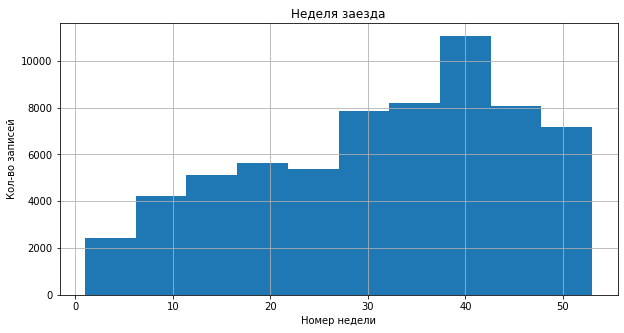

In [12]:
hotel_train['arrival_date_week_number'].hist(figsize=(10, 5), grid=True)
plt.xlabel("Номер недели")
plt.ylabel("Кол-во записей")
plt.title("Неделя заезда")
plt.show()   

* Значения корректные

In [13]:
hotel_train['arrival_date_day_of_month'].value_counts()

17    2565
5     2502
12    2298
16    2297
18    2296
19    2289
30    2272
24    2248
26    2247
20    2244
9     2220
25    2204
7     2164
8     2159
2     2157
28    2152
15    2129
4     2097
21    2092
6     2074
27    2063
3     2040
13    2012
14    1994
11    1972
22    1949
29    1940
10    1846
23    1811
1     1744
31    1152
Name: arrival_date_day_of_month, dtype: int64

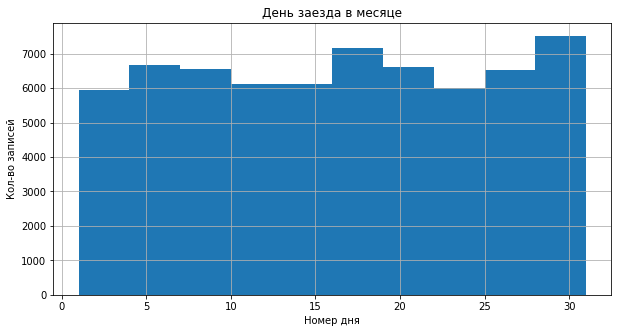

In [14]:
hotel_train['arrival_date_day_of_month'].hist(figsize=(10, 5), grid=True)
plt.xlabel("Номер дня")
plt.ylabel("Кол-во записей")
plt.title("День заезда в месяце")
plt.show() 

* Значения корректные

In [15]:
hotel_train['stays_in_weekend_nights'].value_counts()

0    29738
1    17721
2    17357
3      261
4      152
Name: stays_in_weekend_nights, dtype: int64

* Значения корректные

In [16]:
hotel_train['stays_in_week_nights'].value_counts()

2    20137
1    17850
3    12341
4     5131
5     5128
0     4007
6      635
Name: stays_in_week_nights, dtype: int64

* Значения корректные

In [17]:
hotel_train['adults'].value_counts()

2    48980
1    13212
3     2858
0      166
4       13
Name: adults, dtype: int64

* Значения корректные

In [18]:
hotel_train['children'].value_counts()

0    61712
1     2165
2     1336
3       16
Name: children, dtype: int64

* Значения корректные

In [19]:
hotel_train['babies'].value_counts()

0     64777
1       447
2         3
9         1
10        1
Name: babies, dtype: int64

* Значения корректные

In [20]:
hotel_train['booking_changes'].value_counts()

0     56195
1      6615
2      1754
3       413
4       149
5        42
6        19
7        18
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

* Значения корректные. Почти все значения находятся в диапазон от 0 до 3, более 4 измениней в заказе, практически не встречается. 

In [21]:
hotel_train['country'].value_counts()

PRT    28831
FRA     5974
GBR     5109
ESP     4900
DEU     3887
       ...  
BWA        1
BDI        1
ZWE        1
LCA        1
AND        1
Name: country, Length: 155, dtype: int64

* Значения корректные

In [22]:
hotel_train['customer_type'].value_counts()

Transient          45493
Transient-Party    16703
Contract            2746
Group                287
Name: customer_type, dtype: int64

* Значения корректные

In [23]:
hotel_train['days_in_waiting_list'].value_counts()

0      62005
39       185
58       164
44       137
31       126
       ...  
89         1
76         1
13         1
142        1
14         1
Name: days_in_waiting_list, Length: 97, dtype: int64

* Значения корректные

In [24]:
hotel_train['distribution_channel'].value_counts()

TA/TO        54454
Direct        6853
Corporate     3823
GDS             99
Name: distribution_channel, dtype: int64

* Значения корректные

In [25]:
hotel_train['is_repeated_guest'].value_counts()

0    63458
1     1771
Name: is_repeated_guest, dtype: int64

* Значения корректные

In [26]:
hotel_train['meal'].value_counts()

BB           51697
HB            7292
SC            5274
SC             515
FB             451
Name: meal, dtype: int64

* в данных есть лишние пробелы, поэтому одинаковые данные определяются по разному, необходимо их удалить

Удалим пробелы

In [27]:
hotel_train['meal'] = hotel_train['meal'].str.replace(' ', '')
hotel_train['meal'].value_counts()

BB    51697
HB     7292
SC     5789
FB      451
Name: meal, dtype: int64

* Значения корректные

In [28]:
hotel_train['previous_bookings_not_canceled'].value_counts().head(10)

0    63686
1      645
2      252
3      136
4      114
5       89
6       56
7       34
8       25
9       23
Name: previous_bookings_not_canceled, dtype: int64

* Значения корректные. Почти все значение равны 0 (отсутствуют заказы)

In [29]:
hotel_train['previous_cancellations'].value_counts()

0     59591
1      5367
2        54
3        51
11       35
24       28
25       19
26       18
19       17
5        13
13       12
14       11
6         7
4         5
21        1
Name: previous_cancellations, dtype: int64

* Значения корректные

In [30]:
hotel_train['required_car_parking_spaces'].value_counts()

0    61547
1     3670
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

* Значения корректные

In [31]:
hotel_train['reserved_room_type'].value_counts()

A                   50501
D                    9387
E                    2448
F                    1213
B                     860
G                     592
C                     228
Name: reserved_room_type, dtype: int64

* в данных есть лишние пробелы, необходимо их удалить

In [32]:
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.replace(' ', '')
hotel_train['reserved_room_type'].value_counts()

A    50501
D     9387
E     2448
F     1213
B      860
G      592
C      228
Name: reserved_room_type, dtype: int64

* Значения корректные

In [33]:
hotel_train['total_nights'].value_counts()

2     16795
3     15652
1     12122
4      9629
5      4288
7      3853
6      2078
8       542
9       152
10      118
Name: total_nights, dtype: int64

* Значения корректные

In [34]:
hotel_train['total_of_special_requests'].value_counts()

0    40671
1    16958
2     6444
3     1036
4      107
5       13
Name: total_of_special_requests, dtype: int64

* Значения корректные

***Вывод***
* Данные предобработаны

### Таблица `hotel_test`

Удалим столбец `id`

In [35]:
hotel_test = hotel_test.drop('id', axis=1)

В столбцах `lead_time`, `adults`, `children`, `babies` заменим тип данных на int

In [36]:
hotel_test[['lead_time', 'adults', 'children', 'babies']] = (
    hotel_test[['lead_time', 'adults', 'children', 'babies']].astype('int')
)

Проанализируем данные в столбцах

In [37]:
hotel_test['is_canceled'].value_counts()

0    19821
1    12591
Name: is_canceled, dtype: int64

* Значения корректные

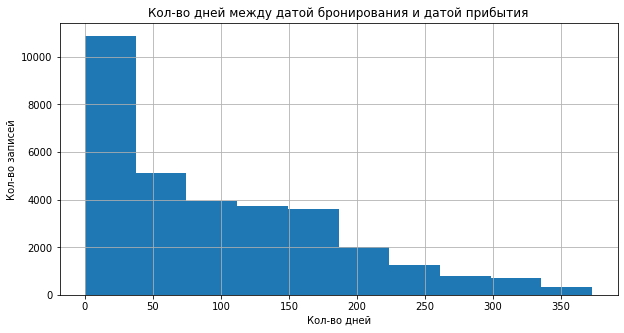

In [38]:
hotel_test['lead_time'].hist(figsize=(10, 5), grid=True)
plt.xlabel("Кол-во дней")
plt.ylabel("Кол-во записей")
plt.title("Кол-во дней между датой бронирования и датой прибытия")
plt.show()    

In [39]:
hotel_test['lead_time'].value_counts()

0      1376
1       783
2       492
3       403
4       391
       ... 
349       2
361       2
347       2
367       2
366       1
Name: lead_time, Length: 368, dtype: int64

* Значения корректные

In [40]:
hotel_test['arrival_date_year'].value_counts()

2017    32412
Name: arrival_date_year, dtype: int64

* Значения корректные

In [41]:
hotel_test['arrival_date_month'].value_counts()

May         5262
April       4878
June        4580
March       4277
July        3626
February    3543
January     3150
August      3096
Name: arrival_date_month, dtype: int64

* Значения корректные

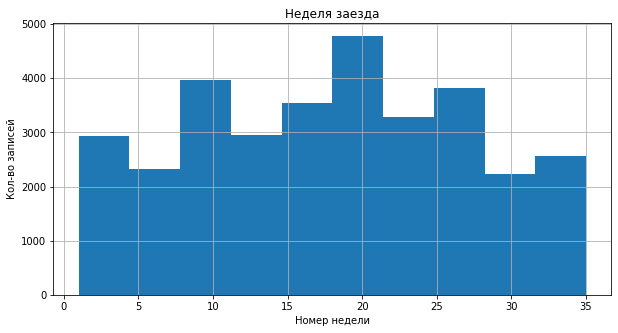

In [42]:
hotel_test['arrival_date_week_number'].hist(figsize=(10, 5), grid=True)
plt.xlabel("Номер недели")
plt.ylabel("Кол-во записей")
plt.title("Неделя заезда")
plt.show()  

In [43]:
hotel_test['arrival_date_week_number'].value_counts().head(10)

17    1297
18    1271
20    1261
15    1218
21    1170
22    1161
14    1101
23    1098
19    1080
8     1054
Name: arrival_date_week_number, dtype: int64

* Значения корректные

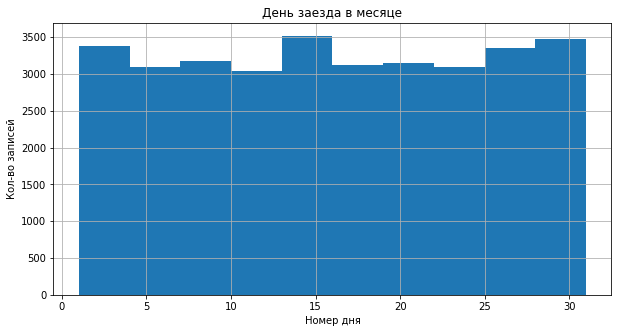

In [44]:
hotel_test['arrival_date_day_of_month'].hist(figsize=(10, 5), grid=True)
plt.xlabel("Номер дня")
plt.ylabel("Кол-во записей")
plt.title("День заезда в месяце")
plt.show() 

In [45]:
hotel_test['arrival_date_day_of_month'].value_counts().head(10)

15    1317
9     1227
2     1200
28    1139
25    1127
3     1121
27    1119
24    1116
14    1115
19    1111
Name: arrival_date_day_of_month, dtype: int64

* Значения корректные

In [46]:
hotel_test['stays_in_weekend_nights'].value_counts()

0    13915
2     9221
1     9105
3      101
4       70
Name: stays_in_weekend_nights, dtype: int64

* Значения корректные

In [47]:
hotel_test['stays_in_week_nights'].value_counts()

2    9004
1    8038
3    7326
4    2975
5    2869
0    1937
6     263
Name: stays_in_week_nights, dtype: int64

* Значения корректные

In [48]:
hotel_test['adults'].value_counts()

2    24237
1     6280
3     1817
0       69
4        9
Name: adults, dtype: int64

* Значения корректные

In [49]:
hotel_test['children'].value_counts()

0    30360
1     1394
2      653
3        5
Name: children, dtype: int64

* Значения корректные

In [50]:
hotel_test['babies'].value_counts()

0    32237
1      171
2        4
Name: babies, dtype: int64

* Значения корректные

In [51]:
hotel_test['booking_changes'].value_counts()

0     27745
1      3065
2      1160
3       268
4       117
5        29
6        16
7         5
16        1
18        1
8         1
10        1
11        1
14        1
15        1
Name: booking_changes, dtype: int64

* Значения корректные

In [52]:
hotel_test['country'].value_counts()

PRT    9887
GBR    3927
FRA    3477
DEU    2378
ESP    1932
       ... 
ASM       1
SLE       1
BHS       1
IMN       1
AND       1
Name: country, Length: 143, dtype: int64

* Значения корректные

In [53]:
hotel_test['customer_type'].value_counts()

Transient          27461
Transient-Party     4427
Contract             359
Group                165
Name: customer_type, dtype: int64

* Значения корректные

In [54]:
hotel_test['days_in_waiting_list'].value_counts()

0      32235
59         6
71         6
60         6
25         6
       ...  
57         1
73         1
105        1
121        1
223        1
Name: days_in_waiting_list, Length: 75, dtype: int64

* Значения корректные

In [55]:
hotel_test['distribution_channel'].value_counts()

TA/TO        27083
Direct        3642
Corporate     1602
GDS             85
Name: distribution_channel, dtype: int64

* Значения корректные

In [56]:
hotel_test['is_repeated_guest'].value_counts()

0    31395
1     1017
Name: is_repeated_guest, dtype: int64

* Значения корректные

In [57]:
hotel_test['meal'].value_counts()

BB           24684
SC            5035
HB            2399
SC             258
FB              36
Name: meal, dtype: int64

* в данных есть лишние пробелы, поэтому одинаковые данные определяются по разному, необходимо их удалить

Удалим пробелы

In [58]:
hotel_test['meal'] = hotel_test['meal'].str.replace(' ', '')
hotel_test['meal'].value_counts()

BB    24684
SC     5293
HB     2399
FB       36
Name: meal, dtype: int64

* Значения корректные

In [59]:
hotel_test['previous_bookings_not_canceled'].value_counts().head(10)

0     31362
1       424
2       161
3        87
4        59
5        46
6        38
7        34
8        24
10       22
Name: previous_bookings_not_canceled, dtype: int64

* Значения корректные

In [60]:
hotel_test['previous_cancellations'].value_counts()

0    32186
1      165
2       29
6       15
4       10
3        6
5        1
Name: previous_cancellations, dtype: int64

* Значения корректные

In [61]:
hotel_test['required_car_parking_spaces'].value_counts()

0    30935
1     1468
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64

* Значения корректные

In [62]:
hotel_test['reserved_room_type'].value_counts()

A                   23471
D                    6123
E                    1644
F                     503
G                     278
C                     201
B                     192
Name: reserved_room_type, dtype: int64

* в данных есть лишние пробелы, необходимо их удалить

In [63]:
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.replace(' ', '')
hotel_test['reserved_room_type'].value_counts()

A    23471
D     6123
E     1644
F      503
G      278
C      201
B      192
Name: reserved_room_type, dtype: int64

* Значения корректные

In [64]:
hotel_test['total_nights'].value_counts()

3     8395
2     6760
4     5828
1     5465
5     2409
7     2284
6      939
8      215
9       62
10      55
Name: total_nights, dtype: int64

* Значения корректные

In [65]:
hotel_test['total_of_special_requests'].value_counts()

0    17338
1    10037
2     3988
3      907
4      124
5       18
Name: total_of_special_requests, dtype: int64

* Значения корректные

### Матрицы корреляций

Создадим датафрейм с числовыми столбцами

In [66]:
hotel_test_number = hotel_train.drop(['arrival_date_year', 'country', 'arrival_date_month',
                                                'meal', 'distribution_channel', 'reserved_room_type', 'customer_type'], axis=1)

Сохраним матрицу корреляций в новую переменную

In [67]:
corr_matrix = hotel_test_number.corr()

Выведем матрицу по частям на экран, для лучшей наглядности

In [68]:
corr_matrix.loc[:, ['is_canceled', 'lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month']]

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month
is_canceled,1.000000,0.328142,0.012869,-0.001903
lead_time,0.328142,1.000000,0.091603,-0.010252
arrival_date_week_number,0.012869,0.091603,1.000000,0.048372
arrival_date_day_of_month,-0.001903,-0.010252,0.048372,1.000000
stays_in_weekend_nights,-0.013767,0.047003,0.034029,-0.002017
stays_in_week_nights,0.010650,0.172646,0.032295,0.003705
adults,0.045153,0.119617,0.005638,0.006034
children,-0.017746,-0.056359,-0.007255,0.018558
babies,-0.029589,-0.024649,0.003938,-0.000482
is_repeated_guest,-0.040242,-0.089424,-0.013471,-0.010605


`is_canceled` (отмена бронирования):

* Обнаружена прямая линейная слабая зависимость (0,328) от кол-ва дней от момента бронирования до момента прибытия;
* Обнаружена обратная линейная слабая зависимость (-0,257) от кол-ва специальных отметок.

`lead_time` (количество дней между датой бронирования и датой прибытия):

* Обнаружена прямая линейная слабая зависимость (0,210) от того сколько дней заказ ожидал подтверждения.

In [69]:
corr_matrix.loc[:, ['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children']]

,stays_in_weekend_nights,stays_in_week_nights,adults,children
is_canceled,-0.013767,0.010650,0.045153,-0.017746
lead_time,0.047003,0.172646,0.119617,-0.056359
arrival_date_week_number,0.034029,0.032295,0.005638,-0.007255
arrival_date_day_of_month,-0.002017,0.003705,0.006034,0.018558
stays_in_weekend_nights,1.000000,0.197410,0.116679,0.026224
stays_in_week_nights,0.197410,1.000000,0.119901,0.023590
adults,0.116679,0.119901,1.000000,-0.003216
children,0.026224,0.023590,-0.003216,1.000000
babies,0.018822,0.018428,0.019756,0.018410
is_repeated_guest,-0.081943,-0.094617,-0.157053,-0.026707


`stays_in_weekend_nights` (количество ночей в выходные дни):

* Обнаружена прямая линейная сильная зависимость (0,645) от общего кол-ва ночей.

`stays_in_week_nights` (количество ночей в будние дни):

* Обнаружена прямая линейная сильная зависимость (0,877) от общего кол-ва ночей.

In [70]:
corr_matrix.loc[:, ['babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled']]

,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled
is_canceled,-0.029589,-0.040242,0.153023,-0.045557
lead_time,-0.024649,-0.089424,0.142454,-0.061690
arrival_date_week_number,0.003938,-0.013471,0.006870,-0.011915
arrival_date_day_of_month,-0.000482,-0.010605,-0.032019,-0.000973
stays_in_weekend_nights,0.018822,-0.081943,-0.008727,-0.025560
stays_in_week_nights,0.018428,-0.094617,-0.006098,-0.049188
adults,0.019756,-0.157053,0.003083,-0.115353
children,0.018410,-0.026707,-0.027357,-0.015807
babies,1.000000,-0.011282,-0.008657,-0.005947
is_repeated_guest,-0.011282,1.000000,0.097786,0.413136


`is_repeated_guest` (признак того, что гость бронирует номер второй раз):

* Обнаружена прямая линейная средняя зависимость (0,413) от количества подтверждённых заказов у клиента.

In [71]:
corr_matrix.loc[:, ['booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces',
                    'total_of_special_requests', 'total_nights']]

,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
is_canceled,-0.142935,0.075848,-0.186486,-0.257061,0.001542
lead_time,-0.007191,0.209741,-0.116867,-0.147738,0.157671
arrival_date_week_number,0.011799,-0.052976,-0.007533,0.076650,0.041886
arrival_date_day_of_month,0.022560,0.017070,0.003816,0.005875,0.001898
stays_in_weekend_nights,0.023118,-0.065167,-0.015870,0.083682,0.644935
stays_in_week_nights,0.061721,0.036037,-0.026988,0.090359,0.876515
adults,-0.056396,-0.013475,0.013321,0.171793,0.150766
children,0.053835,-0.038615,0.047881,0.112699,0.031268
babies,0.076910,-0.013391,0.030264,0.098973,0.023608
is_repeated_guest,0.008570,-0.028772,0.061240,-0.027463,-0.113998


***Вывод***
* Данные предобработаны, можно переходить к оценки прибыли отеля без внедрения депозитов

Обнаружены следующие линейные зависимости:

`is_canceled` (отмена бронирования):

* Прямая линейная слабая зависимость (0,328) от кол-ва дней от момента бронирования до момента прибытия;
* Обратная линейная слабая зависимость (-0,257) от кол-ва специальных отметок.

`lead_time` (количество дней между датой бронирования и датой прибытия):

* Прямая линейная слабая зависимость (0,210) от того сколько дней заказ ожидал подтверждения.

`stays_in_weekend_nights` (количество ночей в выходные дни):

* Прямая линейная сильная зависимость (0,645) от общего кол-ва ночей.

`stays_in_week_nights` (количество ночей в будние дни):

* Прямая линейная сильная зависимость (0,877) от общего кол-ва ночей.

`is_repeated_guest` (признак того, что гость бронирует номер второй раз):

* Прямая линейная средняя зависимость (0,413) от количества подтверждённых заказов у клиента.

## Оценка прибыли отеля без внедрения депозитов

Создадим отдельные таблицы, со столбцами необходимыми для подсчёта прибыли отеля. Для удобства вычислений

In [72]:
profit_train = (hotel_train[['arrival_date_year', 'arrival_date_month', 'total_nights', 'is_canceled',
                             'reserved_room_type']].copy())
profit_test = (hotel_test[['arrival_date_year', 'arrival_date_month', 'total_nights', 'is_canceled',
                             'reserved_room_type']].copy())

Создадим константу со стоимостью номера и затрат на обслуживание, в зависимости от категории номера, константу с повышающим коэфициентом в зависимости от месяца и константу со стоимостью разработки системы прогнозирования. 

In [73]:
ROOM_TYPE = ({'A': [1000, 400], 'B': [800, 350], 'C': [600, 350], 'D': [550, 150], 'E': [500, 150],
              'F': [450, 150], 'G': [350, 150]})
MONTHS = ({'January': 1, 'February': 1, 'March': 1.2, 'April': 1.2, 'May': 1.2, 'June': 1.4, 'July': 1.4,
           'August': 1.4, 'September': 1.2, 'October': 1.2, 'November': 1.2, 'December': 1})
PRICE_MODEL = 0.4

Напишем функцию подсчитывающию прибыль.

In [74]:
def profit (df):
    if df['is_canceled'] == 1:
        return int(-ROOM_TYPE[df['reserved_room_type']][0] * MONTHS[df['arrival_date_month']])
    
    return int(df['total_nights'] * ROOM_TYPE[df['reserved_room_type']][0] * MONTHS[df['arrival_date_month']] -
     (1 + int(df['total_nights'] / 2)) * ROOM_TYPE[df['reserved_room_type']][1])

Вызовем функцию profit для подсчёта, прибыль в таблицах `profit_train` и `profit_test`

In [75]:
profit_train['profit'] = profit_train.apply(profit, 1)
profit_test['profit'] = profit_test.apply(profit, 1)

Найдем прибыль за 2016 год, только за этот год у нас есть полные данные. Прибыль округлим до миллионов, для наглядности.

In [76]:
profit_2016 = profit_train.query('arrival_date_year == 2016')['profit'].sum() / 1000000
print(f'Прибыль за 2016 г.: {profit_2016:.2f} млн. руб.')

Прибыль за 2016 г.: 54.54 млн. руб.


Найдем прибыль за неполный 2017 г. из тестовый выборки, для сравнения с прибылью после внедрения модели

In [77]:
profit_2017 = profit_test.query('arrival_date_year == 2017')['profit'].sum() / 1000000
print(f'Прибыль за 2017 г.: {profit_2017:.2f} млн. руб.')

Прибыль за 2017 г.: 36.87 млн. руб.


Наёдем среднюю прибыль по годам

In [78]:
profit_train.groupby('arrival_date_year')['profit'].mean()

arrival_date_year
2015    1102.642623
2016    1162.848212
Name: profit, dtype: float64

In [79]:
profit_avg_2017 =profit_test['profit'].mean()

Найдём среднюю прибыль за всё время

In [80]:
average_profit = ((profit_train['profit'].sum() + profit_test['profit'].sum()) /
                  (profit_train['profit'].count() + profit_test['profit'].count()))
print(f'Средняя прибыль с одной записи: {average_profit:.2f} руб.')

Средняя прибыль с одной записи: 1143.14 руб.


***Вывод***

* Прибыль за 2016 г.: 54.54 млн. руб.;
* Прибыль за неполный 2017 г.: 36.87 млн. руб.;
* Средняя прибыль с одной записи: 1143.14  руб.;
* Средняя прибыль с одной записи по годам:
    * 2015 г. - 1102.64 руб.;
    * 2016 г. - 1162.85 руб.;
    * 2017 г. - 1137.53 руб.

## Разработка модели ML

* Перемешаем тренирочную выборку, чтобы похожие записи не шли друг за другом, для лучшей обучаемости моделей;
* Извелекём из выборок признаки и целевой признак. Разобьём признаки на числовые и строковые;
* Удалим столбец с годом, так как он не влияет на отказ от брони и не пригодиться в обучение модели.

In [81]:
hotel_train = hotel_train.sample(frac=1, random_state=12345)

hotel_train_features_number = hotel_train.drop(['is_canceled', 'arrival_date_year', 'country', 'arrival_date_month',
                                                'meal', 'distribution_channel', 'reserved_room_type', 'customer_type'], axis=1)
hotel_test_features_number = hotel_test.drop(['is_canceled', 'arrival_date_year', 'country', 'arrival_date_month',
                                                'meal', 'distribution_channel', 'reserved_room_type', 'customer_type'], axis=1)

hotel_train_features_str = hotel_train[['country', 'arrival_date_month', 'meal', 'distribution_channel', 'reserved_room_type',
                                        'customer_type']]
hotel_test_features_str = hotel_test[['country', 'arrival_date_month', 'meal', 'distribution_channel', 'reserved_room_type',
                                        'customer_type']]

hotel_train_target = hotel_train['is_canceled']
hotel_test_target = hotel_test['is_canceled']

Создадим пустой датафрейм для записи результатов модели

In [82]:
table_estimation = pd.DataFrame(columns=['Name', 'F1', 'AUC-ROC', 'Score', 'Profit, m. rub',
         'Profit_avg, rub', 'Profit_growth'])

### Прямое Кодирование

In [83]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(hotel_train_features_str)
hotel_train_features_str = pd.DataFrame(encoder.transform(hotel_train_features_str))
hotel_test_features_str = pd.DataFrame(encoder.transform(hotel_test_features_str))

### Масштабирование признаков

In [84]:
scaler = StandardScaler()
scaler.fit(hotel_train_features_number) 
hotel_train_features_number = pd.DataFrame(scaler.transform(hotel_train_features_number))
hotel_test_features_number  = pd.DataFrame(scaler.transform(hotel_test_features_number))

### Объединение таблиц

In [85]:
hotel_train_features = pd.concat([hotel_train_features_number, hotel_train_features_str], axis=1)
hotel_test_features = pd.concat([hotel_test_features_number, hotel_test_features_str], axis=1)

### Функции

Функция для подсчёта прибыли отеля, после внедрения депозита

In [86]:
def profit_depot (df):
    if df['is_canceled'] == 1:
        if df['is_canceled_model'] == 1:
            return int(-0.2 * ROOM_TYPE[df['reserved_room_type']][0] * MONTHS[df['arrival_date_month']] + 
                       ROOM_TYPE[df['reserved_room_type']][1])
        else:
            return int(-ROOM_TYPE[df['reserved_room_type']][0] * MONTHS[df['arrival_date_month']])
    
    return int(df['total_nights'] * ROOM_TYPE[df['reserved_room_type']][0] * MONTHS[df['arrival_date_month']] -
     (1 + int(df['total_nights'] / 2)) * ROOM_TYPE[df['reserved_room_type']][1])

Функция для подсчёта прибыли модели

In [87]:
def profit_model (df, profit_not_debt, profit_not_debt_avg, predicted):
    profit = (df[['arrival_date_year', 'arrival_date_month', 'total_nights', 'is_canceled',
                             'reserved_room_type']].copy())
    profit['is_canceled_model'] = pd.DataFrame(predicted)
    profit['profit'] = profit.apply(profit_depot, 1)
    profit_dept_avg = profit['profit'].mean()
    print(f'Средняя прибыль после внедрения модели: {profit_dept_avg:.2f}, средняя прибыль выросла на '
          f'{(profit_dept_avg / profit_not_debt_avg - 1):.2%}')
    profit_dept = profit['profit'].sum() / 1000000
    profit_model = profit_dept - profit_not_debt - PRICE_MODEL
    print(f'Прибыль от модели: {profit_model:.2f} млн. руб.')
    

Функция для подсчёта оценок модели и построения ROC-кривой

In [88]:
def estimations_model(model, test_features, test_target, name):
    global table_estimation
    predicted_test = model.predict(test_features)
    probabilities_one_test = model.predict_proba(test_features)[:, 1]
    score = accuracy_score(test_target, predicted_test)
    f1 = f1_score(test_target, predicted_test)
    auc_roc = roc_auc_score(test_target, probabilities_one_test)
    table_estimation = table_estimation.append({'Name':name, 'F1':f1, 'AUC-ROC':auc_roc,'Score':score}, ignore_index=True)
    print(f'Значение F1-меры: {f1:.4f}')
    print(f'Значение AUC-ROC: {auc_roc:.4f}')
    print(f'Доля правильных ответов: {score:.4f}')
    # Построим ROC-кривую
    fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.show()

Функция для подсчёта оценок модели, построения ROC-кривой и подсчёта прибыли модели

In [89]:
def model_info(model, test_features, test_target, profit_not_debt, profit_not_debt_avg, name):
    # Подсчёт оценок модели
    predicted_test = model.predict(test_features)
    probabilities_one_test = model.predict_proba(test_features)[:, 1]
    score =round( accuracy_score(test_target, predicted_test), 4)
    f1 = round(f1_score(test_target, predicted_test), 4)
    auc_roc = round(roc_auc_score(test_target, probabilities_one_test), 4)
    print(f'Значение F1-меры: {f1:.4f}')
    print(f'Значение AUC-ROC: {auc_roc:.4f}')
    print(f'Доля правильных ответов: {score:.4f}')
    # Построим ROC-кривую
    fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.show()
    # Подсчёт прибыли модели
    profit = (hotel_test[['arrival_date_year', 'arrival_date_month', 'total_nights', 'is_canceled',
                             'reserved_room_type']].copy())
    profit['is_canceled_model'] = pd.DataFrame(predicted_test)
    profit['profit'] = profit.apply(profit_depot, 1)
    profit_dept_avg = round(profit['profit'].mean(), 2)
    profit_growth = round((profit_dept_avg / profit_not_debt_avg - 1)*100, 2).astype(str) + '%'
    print(f'Средняя прибыль после внедрения модели: {profit_dept_avg:.2f}, средняя прибыль выросла на '
          f'{profit_growth}')
    profit_dept = profit['profit'].sum() / 1000000
    profit_model = round(profit_dept - profit_not_debt - PRICE_MODEL, 2)
    print(f'Прибыль от модели: {profit_model:.2f} млн. руб.')
    # Добавление результатов в сводную таблицу
    global table_estimation
    table_estimation = table_estimation.append(
        {'Name':name, 'F1':f1, 'AUC-ROC':auc_roc,'Score':score, 'Profit, m. rub': profit_model,
         'Profit_avg, rub':profit_dept_avg, 'Profit_growth':profit_growth}, ignore_index=True)

### Случайный лес

In [90]:
forest_model = RandomForestClassifier(class_weight='balanced', random_state=12345)

Зададим диапазон параметров, для подбора оптимальных гиперпараметров для нашей модели

In [91]:
forest_params = {'n_estimators': range (60,101,20),
                 'max_depth': range (8,13,2)}

С помощью функции GridSearchCV подберём оптимальные гиперпараметры для наше нашей модели

In [92]:
grid = GridSearchCV(forest_model, forest_params, cv=5, scoring='f1')
grid.fit(hotel_train_features, hotel_train_target)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'max_depth': range(8, 13, 2),
                         'n_estimators': range(60, 101, 20)},
             scoring='f1')

Выведем на экран лучшие гиперпараметры

In [93]:
grid.best_params_

{'max_depth': 12, 'n_estimators': 100}

Лучшие гиперпараметры:

* Глубина леса - 12;
* Кол-во деревьев - 100.

Выведем на экран лучший результат

In [94]:
grid.best_score_

0.782496245552687

Проверим нашу лучшую модель на тестовыой выборке и вычислим прибыль

Значение F1-меры: 0.6656
Значение AUC-ROC: 0.8439
Доля правильных ответов: 0.7700


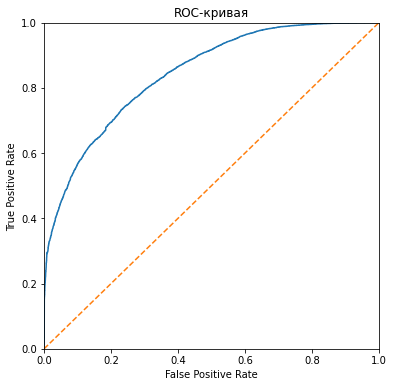

Средняя прибыль после внедрения модели: 1425.19, средняя прибыль выросла на 25.29%
Прибыль от модели: 8.92 млн. руб.


In [95]:
model_info(grid, hotel_test_features, hotel_test_target, profit_2017, profit_avg_2017, 'RandomForest')

In [96]:
 table_estimation

,Name,F1,AUC-ROC,Score,"Profit, m. rub","Profit_avg, rub",Profit_growth
0,RandomForest,0.6656,0.8439,0.77,8.92,1425.19,25.29%


***Вывод***

* Модель окупает себя, чистая прибыль от внедрения модели 8,92 млн. руб.;
* Средняя прибыль после внедрения модели выросла до 1425.19, рост составил - 25.29%;
* Показатели модели на тестовой выборке:
    * Значение F1-меры: 0.6656;
    * Значение AUC-ROC: 0.8439;
    * Доля правильных ответов: 0.77.

### Логистическая регрессия

In [97]:
logit_searcher = LogisticRegressionCV(cv=5, class_weight='balanced', solver='liblinear', random_state=12345)
logit_searcher.fit(hotel_train_features, hotel_train_target)

LogisticRegressionCV(class_weight='balanced', cv=5, random_state=12345,
                     solver='liblinear')

Выведем на экран лучший результат

In [98]:
logit_searcher.score(hotel_train_features, hotel_train_target)

0.791319811740177

Проверим нашу лучшую модель на тестовыой выборке и вычислим прибыль

Значение F1-меры: 0.6732
Значение AUC-ROC: 0.8276
Доля правильных ответов: 0.7591


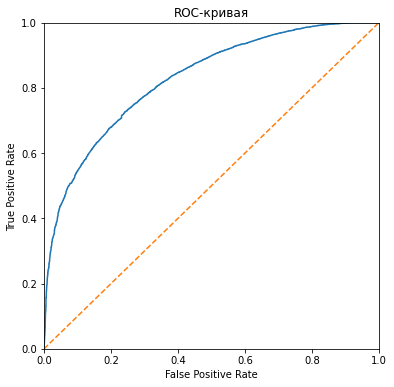

Средняя прибыль после внедрения модели: 1447.16, средняя прибыль выросла на 27.22%
Прибыль от модели: 9.64 млн. руб.


In [99]:
model_info(logit_searcher, hotel_test_features, hotel_test_target, profit_2017, profit_avg_2017, 'LogisticRegression')

***Вывод***

* Модель окупает себя, чистая прибыль от внедрения модели 9,64 млн. руб.;
* Средняя прибыль после внедрения модели выросла до 1447.16, рост составил - 27.22%;
* Показатели модели на тестовой выборке:
    * Значение F1-меры: 0.6732;
    * Значение AUC-ROC: 0.8276;
    * Доля правильных ответов: 0.7591.

### KNN

In [100]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

Зададим диапазон параметров, для подбора оптимальных гиперпараметров для нашей модели

In [101]:
knn_params = {'knn__n_neighbors': range(14, 17,2)}

С помощью функции GridSearchCV подберём оптимальные гиперпараметры для наше нашей модели

In [102]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, scoring="f1")
knn_grid.fit(hotel_train_features, hotel_train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(14, 17, 2)}, scoring='f1')

Выведем на экран лучшие гиперпараметры

In [103]:
knn_grid.best_params_

{'knn__n_neighbors': 14}

Выведем на экран лучший результат

In [104]:
knn_grid.best_score_

0.7418651963023134

Проверим нашу лучшую модель на тестовыой выборке и вычислим прибыль

Значение F1-меры: 0.4807
Значение AUC-ROC: 0.7284
Доля правильных ответов: 0.7018


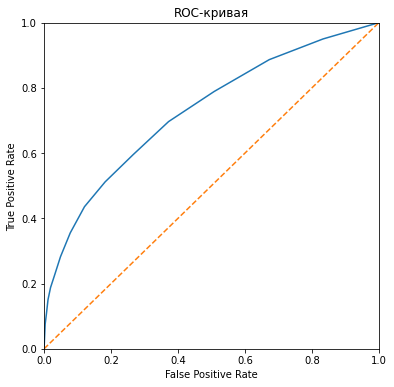

Средняя прибыль после внедрения модели: 1313.92, средняя прибыль выросла на 15.51%
Прибыль от модели: 5.32 млн. руб.


In [105]:
model_info(knn_grid, hotel_test_features, hotel_test_target, profit_2017, profit_avg_2017, 'KNN')

***Вывод***

* Модель окупает себя, чистая прибыль от внедрения модели 5,32 млн. руб.;
* Средняя прибыль после внедрения модели выросла до 1313.92 руб., рост составил - 15.51%;
* Показатели модели на тестовой выборке:
    * Значение F1-меры: 0.4807;
    * Значение AUC-ROC: 0.7284;
    * Доля правильных ответов: 0.7018.

### Вывод

* Лучше всего себя показала модель логистической регрессии, она приносит прибыль 9,64 млн. руб. за неполный 2017 г. Хуже всего себя показала модель KNN, она приносит прибиль 5,32 млн. руб. за неполный 2017 г.;
* Показатели каждой модели:
    * Случайный лес:
        * Модель окупает себя, чистая прибыль от внедрения модели 8,92 млн. руб.;
        * Средняя прибыль после внедрения модели выросла до 1425.19, рост составил - 25.29%;
        * Показатели модели на тестовой выборке:
            * Значение F1-меры: 0.6656;
            * Значение AUC-ROC: 0.8439;
            * Доля правильных ответов: 0.77.
    * Логистическая регрессия:
        * Модель окупает себя, чистая прибыль от внедрения модели 9,64 млн. руб.;
        * Средняя прибыль после внедрения модели выросла до 1447.16, рост составил - 27.22%;
        * Показатели модели на тестовой выборке:
            * Значение F1-меры: 0.6732;
            * Значение AUC-ROC: 0.8276;
            * Доля правильных ответов: 0.7591.
    * KNN:
        * Модель окупает себя, чистая прибыль от внедрения модели 5,32 млн. руб.;
        * Средняя прибыль после внедрения модели выросла до 1313.92 руб., рост составил - 15.51%;
        * Показатели модели на тестовой выборке:
            * Значение F1-меры: 0.4807;
            * Значение AUC-ROC: 0.7284;
            * Доля правильных ответов: 0.7018.

Сводная таблица с моделями и результами:

In [106]:
 table_estimation

,Name,F1,AUC-ROC,Score,"Profit, m. rub","Profit_avg, rub",Profit_growth
0,RandomForest,0.6656,0.8439,0.7700,8.92,1425.19,25.29%
1,LogisticRegression,0.6732,0.8276,0.7591,9.64,1447.16,27.22%
2,KNN,0.4807,0.7284,0.7018,5.32,1313.92,15.51%


## Портрет «ненадёжного» клиента

Создадим список со столбцами для поиска линейной зависимости

In [107]:
COLUMNS_CORR = (['adults', 'arrival_date_day_of_month', 'babies', 'booking_changes', 'children',
            'days_in_waiting_list', 'is_repeated_guest', 'lead_time',
            'previous_bookings_not_canceled', 'previous_cancellations', 'required_car_parking_spaces',
            'stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights', 'total_of_special_requests'])

### Функции

Функция для группировки и вывода обобщённой информации в наглядном формате

In [108]:
def view(df, column):
    x = df.groupby(column)['is_canceled'].agg(['count', 'mean']).query('count > 100').sort_values(by='mean', ascending=False)
    x['mean'] = round(x['mean']*100, 2).astype(str) + '%'
    return x.head(20)

Функция для нахождения корреляции

In [109]:
def func_corr (df_corr, reference):
    for i in COLUMNS_CORR:
        corr = df_corr[reference].corr(df_corr[i])
        if corr > 0.6:
            print(f'{i}: прямая, сильная зависимость, r = {corr:.2}')
        elif 0.4 < corr <= 0.6:
            print(f'{i}: прямая, средняя зависимость, r = {corr:.2}')
        elif 0.2 <= corr <= 0.4:
            print(f'{i}: прямая, слабая зависимость, r = {corr:.2}')
        elif -0.2 < corr < 0.2:
            print(f'{i}: зависимость не значительная, r = {corr:.2}')
        elif -0.4 <= corr <= -0.2:
            print(f'{i}: обратная, слабая зависимость, r = {corr:.2}')
        elif -0.6 <= corr < -0.4:
            print(f'{i}: обратная, средняя зависимость, r = {corr:.2}')
        else:
            print(f'{i}: обратная, сильная зависимость, r = {corr:.2}')

###  Линейная зависимость

In [110]:
func_corr (hotel_train, 'is_canceled')

adults: зависимость не значительная, r = 0.045
arrival_date_day_of_month: зависимость не значительная, r = -0.0019
babies: зависимость не значительная, r = -0.03
booking_changes: зависимость не значительная, r = -0.14
children: зависимость не значительная, r = -0.018
days_in_waiting_list: зависимость не значительная, r = 0.076
is_repeated_guest: зависимость не значительная, r = -0.04
lead_time: прямая, слабая зависимость, r = 0.33
previous_bookings_not_canceled: зависимость не значительная, r = -0.046
previous_cancellations: зависимость не значительная, r = 0.15
required_car_parking_spaces: зависимость не значительная, r = -0.19
stays_in_weekend_nights: зависимость не значительная, r = -0.014
stays_in_week_nights: зависимость не значительная, r = 0.011
total_nights: зависимость не значительная, r = 0.0015
total_of_special_requests: обратная, слабая зависимость, r = -0.26


***Вывод***

* Обнаружена прямая линейная слабая зависимость от кол-ва дней от момента бронирования до момента прибытия;
* Обнаружена обратная линейная слабая зависимость от кол-ва специальных отметок.

### Анализ столбцов на зависимости

Проверим все столбцы и попробуем выявить зависимости

In [111]:
hotel_train.groupby(hotel_train.babies.apply(lambda x: 'Нет' if x == 0 else 'Есть'))['is_canceled'].agg(
    ['count', lambda x: '{:.2%} '.format(x.mean())])

,count,<lambda_0>
babies,,
Есть,452,18.14%
Нет,64777,36.99%


* Клиенты, которые заселяются с младенцами, предположительно в два раза реже отменяют бронь, 18,14% против 36,99%

In [112]:
view(hotel_train, 'adults')

,count,mean
adults,,
2,48980,39.02%
1,13212,30.41%
3,2858,30.27%
0,166,28.92%


* Клиенты с двумя взрослыми постояльцами, предположительно отменяют бронь чуть чаще остальных, 39% против примерно 30% в других категориях

In [113]:
hotel_train.groupby(hotel_train.booking_changes.apply(
    lambda x: 'Нет изменений' if x == 0 else 'Есть изменения'))['is_canceled'].agg(
    ['count', lambda x: '{:.2%} '.format(x.mean())])

,count,<lambda_0>
booking_changes,,
Есть изменения,9034,14.70%
Нет изменений,56195,40.42%


* Клиенты, которые не делали хотя бы одно изменение в заказе, предположительно отменяют бронь гораздо чаще, 40,42% против 14,7%

In [114]:
view(hotel_train, 'children')

,count,mean
children,,
0,61712,37.16%
2,1336,36.53%
1,2165,28.64%


* Клиенты с одним ребёнком в возрасте от 3 до 14 лет, предположительно отменяют бронь реже, 28,64% против примерно 37% у клиентов без детей или с двумя детьми

In [115]:
view(hotel_train, 'country')

,count,mean
country,,
PRT,28831,57.59%
CHN,526,44.49%
TUR,169,40.24%
AGO,140,39.29%
HUN,121,34.71%
MAR,125,34.4%
ITA,2327,32.96%
RUS,296,32.43%
LUX,134,32.09%


* Клиенты из Португалии и Китая, предположительно отменяют бронь чаще остальных, 57,59% и 44,49% соответственно 

In [116]:
view(hotel_train, 'customer_type')

,count,mean
customer_type,,
Contract,2746,39.69%
Transient,45493,39.6%
Transient-Party,16703,29.41%
Group,287,8.36%


* Клиенты, которые оформляют заказ группой, предположительно отменяют бронь намного реже остальных, 8,36% против 29-39% в других типах заказчиков

In [117]:
hotel_train.groupby(hotel_train.days_in_waiting_list.apply(
    lambda x: '0 дней' if x == 0 else 'От 1 дня и больше'))['is_canceled'].agg(
    ['count', lambda x: '{:.2%} '.format(x.mean())])

,count,<lambda_0>
days_in_waiting_list,,
0 дней,62005,35.36%
От 1 дня и больше,3224,65.73%


* Клиенты, которые ожидали подтверждения заказа менее одного дня, предположительно отменяют бронь намного реже, 35,36% против 65,73%

In [118]:
view(hotel_train, 'distribution_channel')

,count,mean
distribution_channel,,
TA/TO,54454,40.41%
Corporate,3823,21.74%
Direct,6853,17.34%


* Клиенты, с каналом дистрибуции "TA/TO", предположительно отменяют бронь намного чаще остальных, 40,41% против 21% и меньше

In [119]:
view(hotel_train, 'is_repeated_guest')

,count,mean
is_repeated_guest,,
0,63458,37.19%
1,1771,25.24%


* Клиенты, которые бронируют номер второй раз, предположительно отменяют бронь рееже, 25,24% против 37,19%

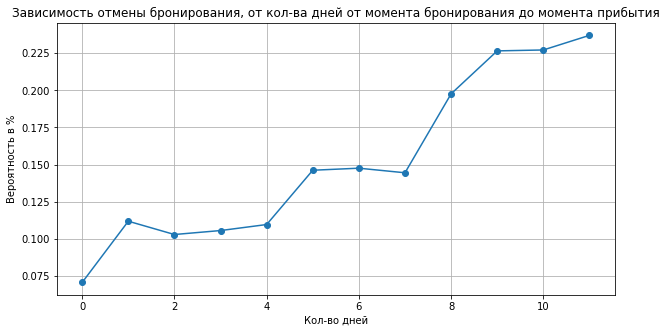

In [120]:
hotel_train.query('lead_time < 12').groupby('lead_time')['is_canceled'].mean().plot(figsize=(10, 5), grid=True, style='-o')
plt.xlabel("Кол-во дней")
plt.ylabel("Вероятность в %")
plt.title("Зависимость отмены бронирования, от кол-ва дней от момента бронирования до момента прибытия")
plt.show()    

* Чем больше кол-во дней от момента бронирования до момента прибытия, тем больше вероятность отказа от брони

In [121]:
view(hotel_train, 'meal')

,count,mean
meal,,
FB,451,68.96%
HB,7292,38.51%
BB,51697,36.63%
SC,5789,34.38%


* Клиенты, у которых включён завтрак, обед и ужин, предположительно отменяют бронь намного чаще остальных, 68,96% против 38,51% и меньше

In [122]:
hotel_train.groupby(hotel_train.previous_bookings_not_canceled.apply(
    lambda x: 'Нет' if x == 0 else 'Есть'))['is_canceled'].agg(
    ['count', lambda x: '{:.2%} '.format(x.mean())])

,count,<lambda_0>
previous_bookings_not_canceled,,
Есть,1543,6.35%
Нет,63686,37.60%


* Клиенты, у которых отсутствуют подтвержденные заказы, предположительно отменяют бронь намного чаще, 37,6% против 6,35%

In [123]:
hotel_train.groupby(hotel_train.previous_cancellations.apply(lambda x: 'Нет' if x == 0 else 'Есть'))['is_canceled'].agg(
    ['count', lambda x: '{:.2%} '.format(x.mean())])

,count,<lambda_0>
previous_cancellations,,
Есть,5638,95.71%
Нет,59591,31.29%


* Клиенты, у которых есть отменённые заказы, предположительно отменяют бронь намного чаще, 95,71% против 31,29%

In [124]:
hotel_train.groupby(hotel_train.required_car_parking_spaces.apply(
    lambda x: 'Не нужно парковочное место' if x == 0 else 'Нужны парковочные места'))['is_canceled'].agg(
    ['count', lambda x: '{:.2%} '.format(x.mean())])

,count,<lambda_0>
required_car_parking_spaces,,
Не нужно парковочное место,61547,39.07%
Нужны парковочные места,3682,0.00%


* Клиенты, которым необходимо парковочное место, предположительно не отменяют бронь

In [125]:
view(hotel_train, 'reserved_room_type')

,count,mean
reserved_room_type,,
A,50501,39.05%
G,592,32.26%
D,9387,30.58%
B,860,30.35%
F,1213,28.69%
E,2448,24.84%
C,228,18.86%


* Клиенты, с заказом номера типа "A", предположительно отменяют бронь чаще остальных (39,05%), а клиенты с заказом номера типа "C" реже остальных (18.86%)

In [126]:
view(hotel_train, 'stays_in_weekend_nights')

,count,mean
stays_in_weekend_nights,,
3,261,37.93%
0,29738,37.67%
2,17357,36.24%
1,17721,36.14%
4,152,30.92%


* Нет чётко выраженной зависимости от кол-ва ночей в выходные дни

In [127]:
view(hotel_train, 'stays_in_week_nights')

,count,mean
stays_in_week_nights,,
2,20137,44.7%
6,635,35.59%
3,12341,35.45%
4,5131,34.85%
5,5128,33.11%
1,17850,32.61%
0,4007,28.33%


* Клиенты, с двумя забронированными будними днями, предположительно отменяют бронь немного чаще остальных, 44,7% против 35,59% и меньше

In [128]:
view(hotel_train, 'total_nights')

,count,mean
total_nights,,
2,16795,45.11%
6,2078,41.0%
3,15652,40.19%
9,152,40.13%
4,9629,35.02%
8,542,33.76%
10,118,32.2%
7,3853,31.85%
5,4288,31.3%


* Клиенты, с двумя забронированными днями, предположительно отменяют бронь немного чаще остальных, 45,1% против 41% и меньше, клиенты с одним забронированным днём, предположительно отменяют бронь реже остальных (25,59%)

In [129]:
hotel_train.groupby(hotel_train.total_of_special_requests.apply(
    lambda x: 'Нет' if x == 0 else 'Есть'))['is_canceled'].agg(
    ['count', lambda x: '{:.2%} '.format(x.mean())])

,count,<lambda_0>
total_of_special_requests,,
Есть,24558,18.50%
Нет,40671,47.95%


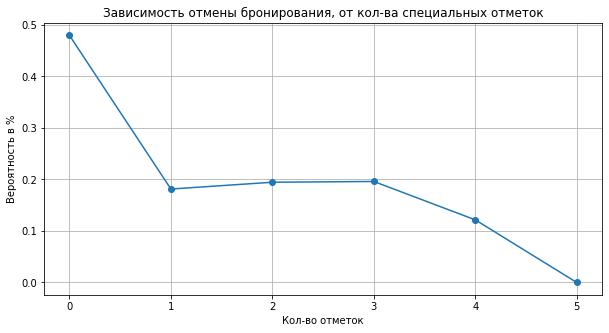

In [130]:
hotel_train.groupby('total_of_special_requests')['is_canceled'].mean().plot(figsize=(10, 5), grid=True, style='-o')
plt.xlabel("Кол-во отметок")
plt.ylabel("Вероятность в %")
plt.title("Зависимость отмены бронирования, от кол-ва специальных отметок")
plt.show()    

* Клиенты, у которых отсутствуют специальные отметки, предположительно отменяют бронь намного чаще, 47,95% против 18,5%. По мере увеличения кол-ва специальных отметок, вероятность отмены бронирования снижается

In [131]:
view(hotel_train, 'arrival_date_month')

,count,mean
arrival_date_month,,
June,4659,41.45%
September,8782,39.71%
April,4804,39.26%
August,6678,38.89%
July,5718,38.84%
October,9255,38.53%
May,4677,35.77%
February,3358,35.2%
December,5497,34.8%


* Клиенты, которые заезжают в отель в июне, предположительно отменяют бронь чаще остальных (41,45%), а клиенты, которые заезжают в отель в январе, предположительно отменяют бронь реже остальных (25,74%)

***Вывод***

Признаки «ненадёжного» клиента:

* Клиенты, которые заселяются без младенцев, предположительная вероятность отмены брони 36,99%, против 18,14%;
* Клиенты, которые не делали хотя бы одно изменение в заказе, предположительная вероятность отмены брони 40,42%, против 14,7%;
* Клиенты из Португалии и Китая, предположительная вероятность отмены брони 57,59% и 44,49% соответственно;
* Клиенты, которые оформляют заказ не группой, предположительная вероятность отмены брони 29-39%, против 8,36%;
* Клиенты, которые ожидали подтверждения заказа от одного дня и более, предположительная вероятность отмены брони 65,73%, против 35,36%;
* Клиенты, с каналом дистрибуции "TA/TO", предположительная вероятность отмены брони 40,41%, против 21% и меньше;
* Клиенты, которые ранее не бронировали номера, предположительная вероятность отмены брони 37,19%, против 25,24% ;
* Чем больше кол-во дней от момента бронирования до момента прибытия, тем выше вероятность отказа клиента от брони;
* Клиенты, у которых включён завтрак, обед и ужин, предположительная вероятность отмены брони 68,96% против 38,51% и меньше;
* Клиенты, у которых отсутствуют подтвержденные заказы, предположительная вероятность отмены брони 37,6% против 6,35%;
* Клиенты, у которых есть отменённые заказы, предположительная вероятность отмены брони 97,48% против 31,29%;
* Клиенты, которым не нужно парковочное место, предположительная вероятность отмены брони 39,07%, а клиенты, которым нужно парковочное место не отменяют бронь;
* Клиенты, с заказом номера типа "A", предположительная вероятность отмены брони 39,05%, против 32,26% и меньше;
* Клиенты, у которых отсутствуют специальные отметки, предположительная вероятность отмены брони 47,95% против 18,5%. По мере увеличения кол-ва специальных отметок, вероятность отмены бронирования снижается.

## Общий вывод

* Рекомендую внедрить модель логистической регрессии, она приносит наибольшую прибыль - 9,64 млн. руб. за неполный 2017 г.
* Показатели каждой модели:
    * Случайный лес:
        * Модель окупает себя, чистая прибыль от внедрения модели 8,92 млн. руб.;
        * Средняя прибыль после внедрения модели выросла до 1425.19, рост составил - 25.29%;
        * Показатели модели на тестовой выборке:
            * Значение F1-меры: 0.6656;
            * Значение AUC-ROC: 0.8439;
            * Доля правильных ответов: 0.77.
    * Логистическая регрессия:
        * Модель окупает себя, чистая прибыль от внедрения модели 9,64 млн. руб.;
        * Средняя прибыль после внедрения модели выросла до 1447.16, рост составил - 27.22%;
        * Показатели модели на тестовой выборке:
            * Значение F1-меры: 0.6732;
            * Значение AUC-ROC: 0.8276;
            * Доля правильных ответов: 0.7591.
    * KNN:
        * Модель окупает себя, чистая прибыль от внедрения модели 5,32 млн. руб.;
        * Средняя прибыль после внедрения модели выросла до 1313.92 руб., рост составил - 15.51%;
        * Показатели модели на тестовой выборке:
            * Значение F1-меры: 0.4807;
            * Значение AUC-ROC: 0.7284;
            * Доля правильных ответов: 0.7018.

Сводная таблица с моделями и результами:

In [132]:
 table_estimation

,Name,F1,AUC-ROC,Score,"Profit, m. rub","Profit_avg, rub",Profit_growth
0,RandomForest,0.6656,0.8439,0.7700,8.92,1425.19,25.29%
1,LogisticRegression,0.6732,0.8276,0.7591,9.64,1447.16,27.22%
2,KNN,0.4807,0.7284,0.7018,5.32,1313.92,15.51%


Признаки «ненадёжного» клиента:

* Клиенты, которые заселяются без младенцев, предположительная вероятность отмены брони 36,99%, против 18,14%;
* Клиенты, которые не делали хотя бы одно изменение в заказе, предположительная вероятность отмены брони 40,42%, против 14,7%;
* Клиенты из Португалии и Китая, предположительная вероятность отмены брони 57,59% и 44,49% соответственно;
* Клиенты, которые оформляют заказ не группой, предположительная вероятность отмены брони 29-39%, против 8,36%;
* Клиенты, которые ожидали подтверждения заказа от одного дня и более, предположительная вероятность отмены брони 65,73%, против 35,36%;
* Клиенты, с каналом дистрибуции "TA/TO", предположительная вероятность отмены брони 40,41%, против 21% и меньше;
* Клиенты, которые ранее не бронировали номера, предположительная вероятность отмены брони 37,19%, против 25,24% ;
* Чем больше кол-во дней от момента бронирования до момента прибытия, тем выше вероятность отказа клиента от брони;
* Клиенты, у которых включён завтрак, обед и ужин, предположительная вероятность отмены брони 68,96% против 38,51% и меньше;
* Клиенты, у которых отсутствуют подтвержденные заказы, предположительная вероятность отмены брони 37,6% против 6,35%;
* Клиенты, у которых есть отменённые заказы, предположительная вероятность отмены брони 97,48% против 31,29%;
* Клиенты, которым не нужно парковочное место, предположительная вероятность отмены брони 39,07%, а клиенты, которым нужно парковочное место не отменяют бронь;
* Клиенты, с заказом номера типа "A", предположительная вероятность отмены брони 39,05%, против 32,26% и меньше;
* Клиенты, у которых отсутствуют специальные отметки, предположительная вероятность отмены брони 47,95% против 18,5%. По мере увеличения кол-ва специальных отметок, вероятность отмены бронирования снижается.